In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from time import time

# TODO: Move functions to separate modules
import functions as f

import core.background_model as background_model
import core.clique_finding as cf
import core.stats 

# GLOBALS

TTN_BIN = 4275
BIN_MAP_PATH = 'mappings/bin_map_human_100000.bed'
GTF_PATH = 'mappings/gencode.v38.annotation.gtf'
GENE_BIN_PATH = 'mappings/gene_bins.txt'
NON_GENE_BIN_PATH = 'mappings/non_gene_bins.txt'


gene_bins = []
with open('mappings/gene_bins.txt', 'r') as file:
    for line in file:
        gene_bins.append(line.strip())
gene_bins = [int(x) for x in gene_bins]


non_gene_bins = []
with open('mappings/non_gene_bins.txt', 'r') as file:
    for line in file:
        non_gene_bins.append(line.strip())
non_gene_bins = [int(x) for x in non_gene_bins]



In [ ]:
contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed_no_chrY.npy')

In [40]:
contact_matrix_zero = f.generate_sample_matrix_bins(2000)

In [36]:
TTN_BIN = 70

## Smart Diffusion (only optimizing alpha)

In [106]:
import core.optimizer



res = core.optimizer.optimize_diffusion_params_smart(contact_matrix_zero, TTN_BIN, (5,50), (0.01, 0.95), n_trials=5, timeout_minutes=1)

[I 2025-05-25 04:13:58,487] A new study created in memory with name: no-name-fcb21c10-43f9-468e-be5f-d4673f498781
α = 0.010: 100%|██████████| 46/46 [00:07<00:00,  5.79it/s]
[I 2025-05-25 04:14:06,787] Trial 0 finished with value: 0.3745 and parameters: {'alpha': 0.01}. Best is trial 0 with value: 0.3745.
α = 0.950: 100%|██████████| 46/46 [00:08<00:00,  5.32it/s]
[I 2025-05-25 04:14:15,784] Trial 1 finished with value: 0.175 and parameters: {'alpha': 0.95}. Best is trial 1 with value: 0.175.
α = 0.472: 100%|██████████| 46/46 [00:07<00:00,  5.80it/s]
[I 2025-05-25 04:14:24,035] Trial 2 finished with value: 0.185 and parameters: {'alpha': 0.4715985004978831}. Best is trial 1 with value: 0.175.
α = 0.112: 100%|██████████| 46/46 [00:07<00:00,  5.76it/s]
[I 2025-05-25 04:14:32,340] Trial 3 finished with value: 0.491 and parameters: {'alpha': 0.11166365269345857}. Best is trial 1 with value: 0.175.
α = 0.625: 100%|██████████| 46/46 [00:08<00:00,  5.71it/s]
[I 2025-05-25 04:14:40,745] Trial 4 

In [107]:
res

{'best_alpha': 0.95,
 'best_k': 5,
 'best_clique': array([ 70,  84, 164,  24, 109]),
 'final_pval': 0.175,
 'final_fold': 1.376928368763567,
 'full_log': [{'alpha': 0.01,
   'k': 5,
   'pval': 0.995,
   'fold_change': 0.7099154605137764},
  {'alpha': 0.01, 'k': 6, 'pval': 0.9635, 'fold_change': 0.8323460810853577},
  {'alpha': 0.01, 'k': 7, 'pval': 0.8755, 'fold_change': 0.9088476086995223},
  {'alpha': 0.01, 'k': 8, 'pval': 0.972, 'fold_change': 0.8876712703624575},
  {'alpha': 0.01, 'k': 9, 'pval': 0.869, 'fold_change': 0.9385649078042128},
  {'alpha': 0.01, 'k': 10, 'pval': 0.7165, 'fold_change': 0.9689668646567253},
  {'alpha': 0.01, 'k': 11, 'pval': 0.7135, 'fold_change': 0.9734829898807728},
  {'alpha': 0.01, 'k': 12, 'pval': 0.7115, 'fold_change': 0.9777798901448026},
  {'alpha': 0.01, 'k': 13, 'pval': 0.749, 'fold_change': 0.9740591378516392},
  {'alpha': 0.01, 'k': 14, 'pval': 0.704, 'fold_change': 0.9816591749022524},
  {'alpha': 0.01, 'k': 15, 'pval': 0.593, 'fold_change': 0

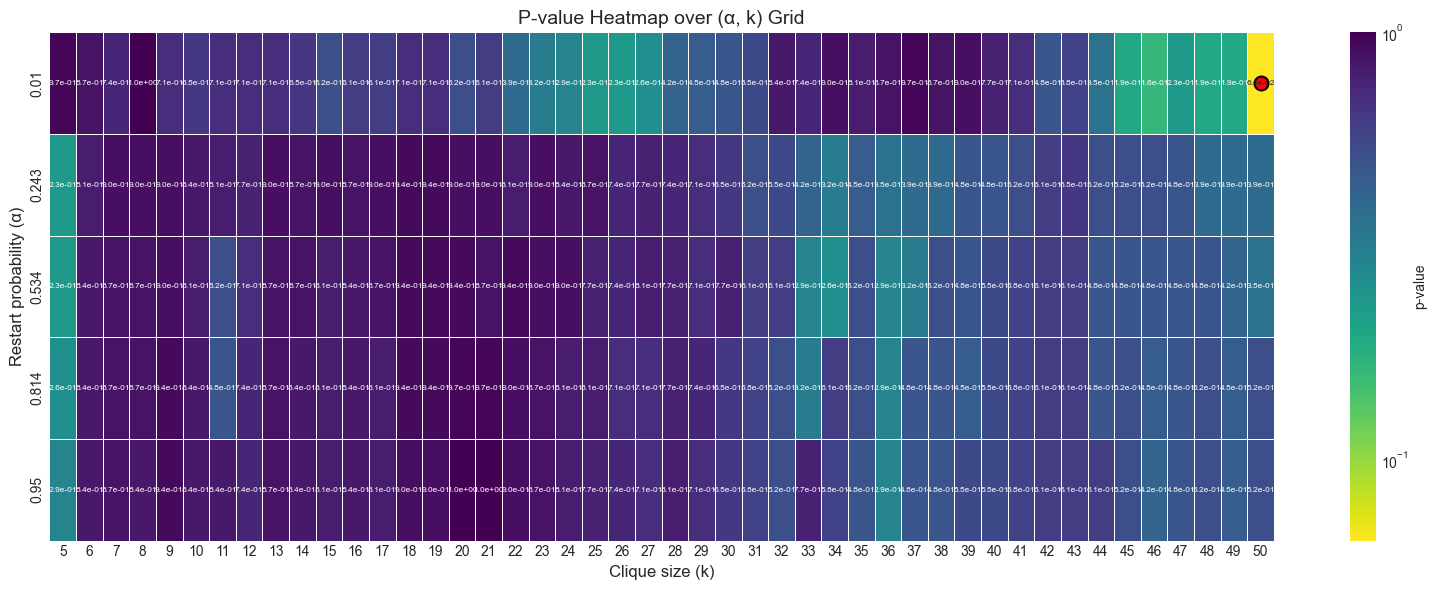

In [102]:
import core.visuals


core.visuals.plot_pval_heatmap_from_log('full_alpha_k_log.csv')

## Testing

In [61]:
import numpy as np
import pandas as pd
import optuna
from tqdm import tqdm
import core.stats

def optimize_diffusion_params_smart(
    contact_matrix: np.ndarray,
    seed_bin: int,
    k_range=(5, 50),
    alpha_bounds=(0.01, 0.95),
    n_trials: int = 50,
    timeout_minutes: int = 120,
    log_csv: str = "full_alpha_k_log.csv",
):
    N = contact_matrix.shape[0]

    # Build row-stochastic transition matrix P
    P = np.zeros((N, N), dtype=float)
    row_sums = contact_matrix.sum(axis=1)
    for i in range(N):
        if row_sums[i] > 0:
            P[i, :] = contact_matrix[i, :] / row_sums[i]
        else:
            P[i, i] = 1.0
    I = np.eye(N)

    all_trials_log = []

    study = optuna.create_study(direction="minimize")

    def objective(trial):
        alpha = trial.suggest_float("alpha", *alpha_bounds)
        A = I - (1 - alpha) * P
        F = np.linalg.inv(A)
        sorted_ranks = [np.argsort(F[i])[::-1] for i in range(N)]

        best_p = np.inf
        for k in tqdm(range(k_range[0], k_range[1] + 1), desc=f"α = {alpha:.3f}"):
            clique = sorted_ranks[seed_bin][:k]
            ttn_score = core.stats.calculate_avg_interaction_strength(contact_matrix, clique)

            bg_scores = [
                core.stats.calculate_avg_interaction_strength(contact_matrix, sorted_ranks[i][:k])
                for i in range(N) if i != seed_bin
            ]
            bg_scores = np.array(bg_scores)
            pval = core.stats.empirical_p_value(ttn_score, bg_scores)
            fold = ttn_score / (np.median(bg_scores) + 1e-10)

            # Save log
            trial_data = {
                "alpha": alpha,
                "k": k,
                "pval": pval,
                "fold_change": fold,
            }
            all_trials_log.append(trial_data)

            # Add this k-trial manually to the study
            manual_trial = optuna.trial.create_trial(
                params={"alpha": alpha, "k": k},
                distributions={
                    "alpha": optuna.distributions.FloatDistribution(*alpha_bounds),
                    "k": optuna.distributions.IntDistribution(*k_range)
                },
                value=pval,
                user_attrs={"fold_change": fold}
            )
            study.add_trial(manual_trial)

            best_p = min(best_p, pval)

        return best_p

    # Run the alpha-only optimizer which populates k trials inside
    study.optimize(objective, n_trials=n_trials, timeout=timeout_minutes * 60)

    # Get best (alpha, k) from full Optuna record
    best_alpha = study.best_trial.params["alpha"]
    best_k = study.best_trial.params["k"]
    final_pval = study.best_trial.value
    final_fold = study.best_trial.user_attrs["fold_change"]

    # Compute final best clique
    A = I - (1 - best_alpha) * P
    F = np.linalg.inv(A)
    sorted_ranks = [np.argsort(F[i])[::-1] for i in range(N)]
    best_clique = sorted_ranks[seed_bin][:best_k]

    # Save full log to CSV
    pd.DataFrame(all_trials_log).to_csv(log_csv, index=False)

    return {
        "best_alpha": best_alpha,
        "best_k": best_k,
        "best_clique": best_clique,
        "final_pval": final_pval,
        "final_fold": final_fold,
        "optuna_study": study,
        "full_log": all_trials_log
    }

In [71]:
import core.optimizer


res = optimize_diffusion_params_smart(contact_matrix_zero, TTN_BIN, (2,50), (0.01, 0.95), n_trials=10, timeout_minutes=200)

[I 2025-05-24 23:57:45,439] A new study created in memory with name: no-name-a18634b5-1641-4ce5-90cc-76cc1210230f
α = 0.219: 100%|██████████| 49/49 [00:07<00:00,  6.13it/s]
[I 2025-05-24 23:57:53,794] Trial 0 finished with value: 0.1775 and parameters: {'alpha': 0.21886686361165658}. Best is trial 4 with value: 0.1775.
α = 0.133: 100%|██████████| 49/49 [00:08<00:00,  5.94it/s]
[I 2025-05-24 23:58:02,375] Trial 50 finished with value: 0.127 and parameters: {'alpha': 0.13313133541330505}. Best is trial 54 with value: 0.127.
α = 0.273: 100%|██████████| 49/49 [00:07<00:00,  6.15it/s]
[I 2025-05-24 23:58:10,705] Trial 100 finished with value: 0.185 and parameters: {'alpha': 0.27268778157026885}. Best is trial 54 with value: 0.127.
α = 0.184: 100%|██████████| 49/49 [00:07<00:00,  6.13it/s]
[I 2025-05-24 23:58:19,043] Trial 150 finished with value: 0.168 and parameters: {'alpha': 0.1838508328492992}. Best is trial 54 with value: 0.127.
α = 0.325: 100%|██████████| 49/49 [00:08<00:00,  6.03it/s

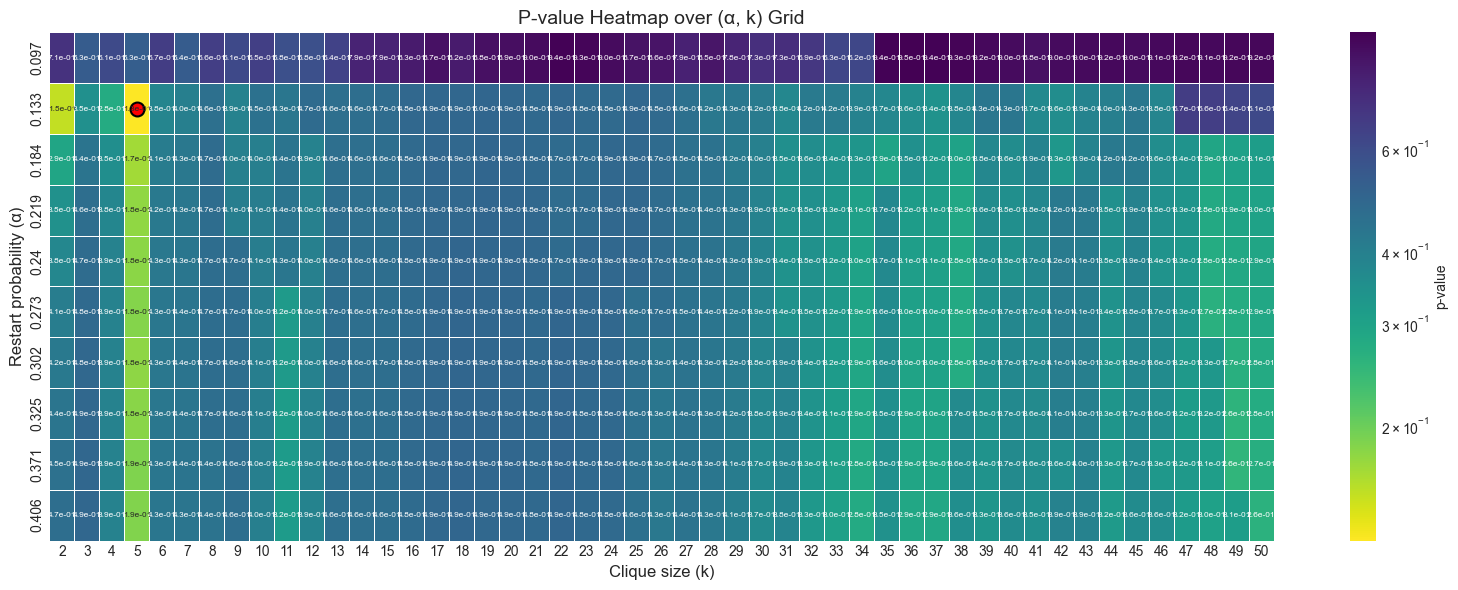

In [72]:
import core.visuals


core.visuals.plot_pval_heatmap_from_log('full_alpha_k_log.csv')

## Slower Diffusion (optimize alpha and k)

In [55]:
import core.optimizer


best_alpha, best_k, best_clique, final_pval, trial_history = core.optimizer.optimize_diffusion_params(contact_matrix_zero, TTN_BIN, (5,100), (0.01, 0.95), n_trials=5, timeout_minutes=200)

[I 2025-05-24 23:43:02,375] A new study created in memory with name: no-name-3fb1906a-dc0b-4f54-ad0c-98e8f47baaae
[I 2025-05-24 23:43:03,808] Trial 0 finished with value: 0.1835 and parameters: {'alpha': 0.5590501576339365, 'k': 74}. Best is trial 0 with value: 0.1835.
[I 2025-05-24 23:43:04,644] Trial 1 finished with value: 0.2955 and parameters: {'alpha': 0.5143030701015863, 'k': 48}. Best is trial 0 with value: 0.1835.
[I 2025-05-24 23:43:06,721] Trial 2 finished with value: 0.08 and parameters: {'alpha': 0.7367515332380457, 'k': 94}. Best is trial 2 with value: 0.08.
[I 2025-05-24 23:43:07,965] Trial 3 finished with value: 0.277 and parameters: {'alpha': 0.33542048348674275, 'k': 70}. Best is trial 2 with value: 0.08.
[I 2025-05-24 23:43:08,315] Trial 4 finished with value: 0.1845 and parameters: {'alpha': 0.43441679576262215, 'k': 5}. Best is trial 2 with value: 0.08.


In [56]:
pd.DataFrame(trial_history)

,alpha,k,pval,fold_change
0,0.736752,94,0.0800,1.616204
1,0.559050,74,0.1835,1.046980
2,0.434417,5,0.1845,1.315126
3,0.335420,70,0.2770,1.015362
4,0.514303,48,0.2955,1.023523


In [57]:
best_alpha, best_k, best_clique, final_pval

(0.7367515332380457,
 94,
 array([ 70, 164,  84,  24, 109, 189, 134,  13, 124,  79, 161,  69,  85,
         44, 118, 112, 171, 148,   4, 159, 191, 163,  76, 117, 105, 123,
         18, 152,  92, 100,  82,  10, 185, 197,  60, 194, 102, 137, 142,
        136, 104,  97, 113, 155, 184, 131, 182, 198,  91, 122,  49,  52,
         57, 132,  66, 141, 101, 187, 158,  75,  53,  17, 181,  22,  35,
        146,  98,  48, 128,  39,  71, 162,  38, 138,  93,  64,   9,  40,
          8, 149, 119, 180,  30, 178,  67, 139, 127,  42, 168,  72, 144,
        145,  95,   2]),
 0.08)

In [28]:
pd.DataFrame(trial_history)

,alpha,k,pval,fold_change
0,0.869865,11,0.012,1.288248
1,0.861430,11,0.012,1.288248
2,0.924103,11,0.012,1.472030
3,0.929591,11,0.012,1.472030
4,0.918928,11,0.012,1.472030
...,...,...,...,...
95,0.903701,34,0.451,1.543413
96,0.364892,87,0.476,1.003497
97,0.073177,67,0.958,0.974797
98,0.014243,41,0.979,0.987375


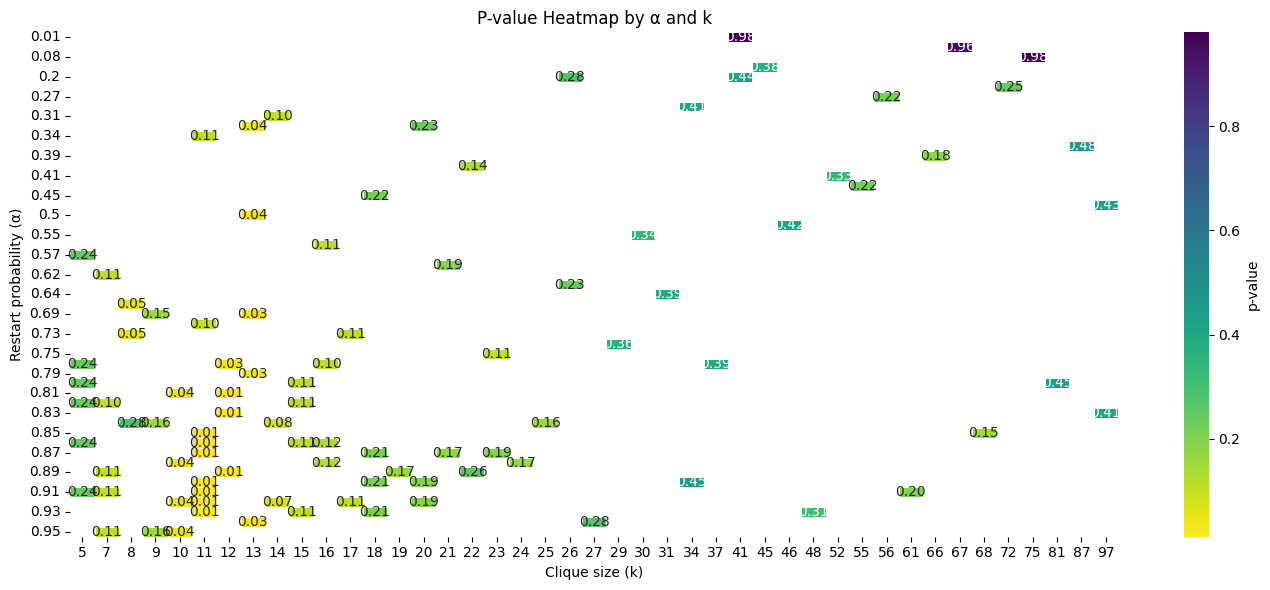

In [30]:
import core.visuals

core.visuals.plot_pval_heatmap_from_trials(pd.DataFrame(trial_history), alpha_precision=2)


In [31]:
import core.optimizer
import core.visuals


sizes, ttn_scores, p_values, fold_changes, bg_dists = core.optimizer.optimize_clique_size_diffusion(contact_matrix_zero, max_clique_size=100, seed_bin=TTN_BIN, alpha=best_alpha)

🔄 Computing full analytical diffusion matrix F…
✔︎ TTN seed clique (size 100) ready
✔︎ Built background cliques for all 1000 seeds


Processing sizes: 100%|██████████| 100/100 [00:31<00:00,  3.13it/s]

✅ Done optimize_clique_size_analytical


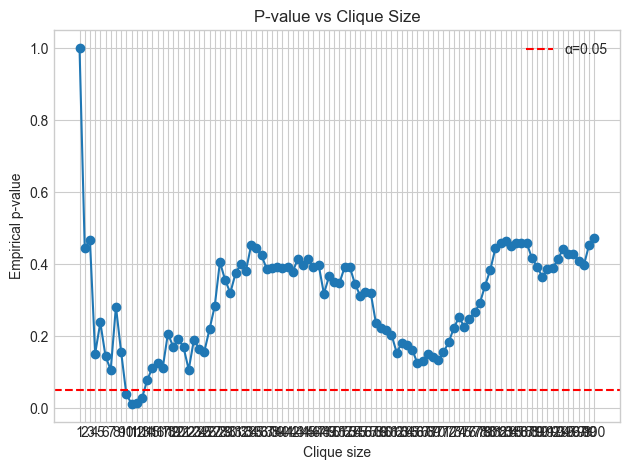

Optimal clique size = 11, p-value = 0.0130


In [32]:
core.visuals.plot_clique_size_optimization(sizes, p_values)